In [354]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
import os

In [355]:
# Recherche des numéros des classes pour utilisation ultérieure
image_path = './Data/val/GT/patient001_01_4.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Obtenir les valeurs uniques des pixels dans l'image
class_numbers = np.unique(img)

print("Nombre de classes : ", len(class_numbers))
print("Numéros de classe présents dans l'image : ", class_numbers)

Nombre de classes :  4
Numéros de classe présents dans l'image :  [  0  85 170 255]


In [356]:
def dice_coefficient(path_img1, path_img2):
    dice_coeff = 0
    for class_number in class_numbers:
        # Lecture des images
        img1 = cv2.imread(path_img1, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(path_img2, cv2.IMREAD_GRAYSCALE)

        
        mask1 = (img1 == class_number)
        mask2 = (img2 == class_number)

        # Calculer les valeurs TP, FP, FN
        tp = np.sum(np.logical_and(mask1, mask2))
        fp = np.sum(np.logical_and(np.logical_not(mask1), mask2))
        fn = np.sum(np.logical_and(mask1, np.logical_not(mask2)))

        # Calculer le coefficient de Dice
        dice_coeff += (2 * tp) / (2 * tp + fp + fn)

    return dice_coeff / len(class_numbers)


In [357]:
def hausdorff_distance(path_img1, path_img2):
    img1 = cv2.imread(path_img1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(path_img2, cv2.IMREAD_GRAYSCALE)

    # Appliquer un seuillage pour binariser les images
    _, thresh1 = cv2.threshold(img1, 128, 255, cv2.THRESH_BINARY)
    _, thresh2 = cv2.threshold(img2, 128, 255, cv2.THRESH_BINARY)

    # Trouver les contours des images binaires
    contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Au cas où on n'arrive pas à trouver de contours
    if not contours1 or not contours2:
        return 10000 #normalement return float('inf')
    
    # Extraire les points des contours
    points1 = np.vstack(contours1).squeeze()
    points2 = np.vstack(contours2).squeeze()

    # Retouner la valeur max entre H(p1,p2) et H(p2,p1)
    return max(directed_hausdorff(points1,points2)[0], directed_hausdorff(points2,points1)[0])

In [358]:
def accuracy_coefficient(path_img1,path_img2):
    accuracy = 0
    for class_number in class_numbers:
        img1 = cv2.imread(path_img1, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(path_img2, cv2.IMREAD_GRAYSCALE)

        mask1 = (img1 == class_number)
        mask2 = (img2 == class_number)

        # Calculer les valeurs TP, TN, FP, FN
        tp = np.sum(np.logical_and(mask1, mask2))
        tn = np.sum(np.logical_and(np.logical_not(mask1), np.logical_not(mask2)))
        fp = np.sum(np.logical_and(np.logical_not(mask1), mask2))
        fn = np.sum(np.logical_and(mask1, np.logical_not(mask2)))

        # Calculer le coefficient de Dice
        accuracy += (tp + tn) / (tp + tn + fp + fn)

    return accuracy / len(class_numbers)

In [359]:
def compare_imgs(path_img1, path_img2):
    dice_coeff = dice_coefficient(path_img1, path_img2)
    accuracy = accuracy_coefficient(path_img1, path_img2)
    hausdorff_dist = hausdorff_distance(path_img1, path_img2)
    return dice_coeff, accuracy, hausdorff_dist

In [360]:
def compare_folders(labels_folder, predictions_folder):
    # Liste des fichiers dans les dossiers des labels et des prédictions
    labels_files = os.listdir(labels_folder)
    predictions_files = os.listdir(predictions_folder)

    if len(labels_files) == len(predictions_files):
        print("Les dossiers n'ont pas le même nombre de fichiers.")

    # Variables pour stocker les résultats des métriques
    dice_coeff_values = []
    accuracy_coeff_values = []
    hausdorff_dist_values = []

    # Itération sur chaque paire label/prédiction
    for label_file, prediction_file in zip(labels_files, predictions_files):
        label_image_path = os.path.join(labels_folder, label_file)
        prediction_image_path = os.path.join(predictions_folder, prediction_file)

        # Calculer les métriques pour la paire d'images actuelle
        metrics = compare_imgs(label_image_path, prediction_image_path)

        # Ajouter les résultats aux totaux
        dice_coeff_values.append(metrics[0])
        accuracy_coeff_values.append(metrics[1])
        hausdorff_dist_values.append(metrics[2])

    return dice_coeff_values, accuracy_coeff_values, hausdorff_dist_values

In [361]:
def plot_metrics(dice_values, accuracy_values, hausdorff_values):
    # Tracer les valeurs des métriques
    plt.figure(figsize=(10, 6))

    plt.subplot(3, 1, 1)
    plt.plot(dice_values, marker='o')
    plt.title('Coefficient de Dice')

    plt.subplot(3, 1, 2)
    plt.plot(accuracy_values, marker='o')
    plt.title('Coefficient de précision')

    plt.subplot(3, 1, 3)
    plt.plot(hausdorff_values, marker='o')
    plt.title('Distance de Hausdorff')

    plt.tight_layout()
    plt.show()

Mean Dice coeff =  0.1702975485263986
Mean Accuracy =  0.7007064819335938
Mean Hausdorff distance =  2017.6805793186923


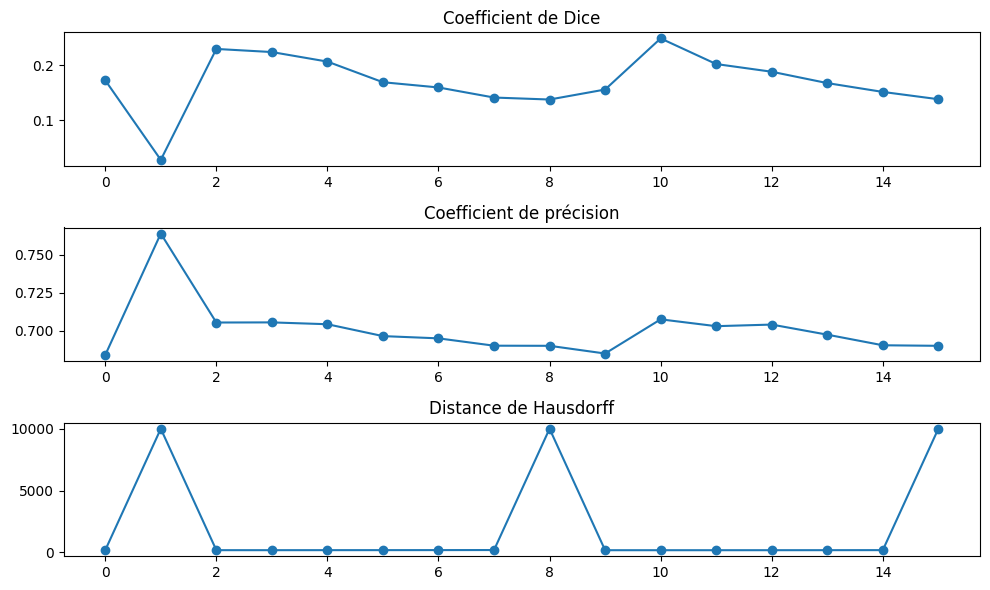

In [362]:
labels_folder = './Data all labelled/test/GT'
predictions_folder = './img/predictions'

metrics = compare_folders(labels_folder,predictions_folder)

print('Mean Dice coeff = ', np.mean(metrics[0]))
print('Mean Accuracy = ', np.mean(metrics[1]))
print('Mean Hausdorff distance = ', np.mean(metrics[2]))
plot_metrics(metrics[0],metrics[1],metrics[2])
